In [2]:
import numpy as np
import pandas as pd

from __future__ import print_function
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import logging
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, MaxPooling1D, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2



In [4]:
from sklearn import preprocessing

df_dataset1 = pd.read_csv('deceptive-opinion.csv')
df_dataset1=df_dataset1.drop(["hotel","polarity","source"],axis=1)

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df_dataset1['deceptive']= label_encoder.fit_transform(df_dataset1['deceptive'])

df_dataset2 = pd.read_csv('fake reviews dataset.csv')
df_dataset2 = df_dataset2.drop(["category","rating"], axis=1)
df_dataset2 = df_dataset2.sample(frac=1)

label_encoder = preprocessing.LabelEncoder()

df_dataset2['label']= label_encoder.fit_transform(df_dataset2['label'])

df_dataset2.columns = ['deceptive', 'text']
df = pd.concat([df_dataset1, df_dataset2], axis = 0)
df.groupby('deceptive').describe()

text                                                            \
           count unique                                                top   
deceptive                                                                    
0          21016  20997  This is the first book in a series by the auth...   
1          21016  21011  Very disappointed in our stay in Chicago Monoc...   

                
          freq  
deceptive       
0            2  
1            2

In [10]:
import nltk
import re
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
def clean_text(text):

    ## Remove puncuation
    text = text.translate(string.punctuation)
    ## Convert words to lower case and split them
    text = text.lower().split()
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [word for word in text if not word in stops and len(word) >= 3]
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_char(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x

In [12]:
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [13]:
df['text'] = df['text'].map(lambda a: clean_numbers(a))
df['text'] = df['text'].map(lambda a: clean_char(a))
df['text'] = df['text'].map(lambda a: clean_text(a))
df['text']

,text
0,stay one night getaway famili thursday tripl a...
1,tripl rate upgrad view room less also includ b...
2,come littl late final catch review past sever ...
3,omni chicago realli deliv front spacious room ...
4,ask high floor away elev got room pleasant dec...
...,...
4783,bad piec bought sever brand knive famili friend
18964,decent right angl clamp built aluminum jaw ste...
23772,love clay paisley love book seri read book
32863,daughter go love amaz custom servic


In [14]:
x = df['text']
y = df['deceptive']

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=5)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

Number of rows in the total set: 42032
Number of rows in the training set: 31524
Number of rows in the test set: 10508


In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

tokenizer = Tokenizer(num_words=None,lower=True,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=' ',char_level=False)
tokenizer.fit_on_texts(x)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index
x = tokenizer.texts_to_sequences(x)

In [17]:
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in x)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in x])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in x])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))

Vocab size: 27288
Longest comment size: 371
Average comment size: 32.691282832127904
Stdev of comment size: 34.242227175746144
Max comment size: 135


In [18]:
from keras.preprocessing.sequence import pad_sequences
processed_post_x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
processed_post_x_test = pad_sequences(x_test, maxlen=max_len, padding='post', truncating='post')
processed_x_train = pad_sequences(x_train, maxlen=max_len)
processed_x_test = pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', processed_x_train.shape)
print('x_test shape:', processed_x_test.shape)

x_train shape: (31524, 135)
x_test shape: (10508, 135)


In [19]:
import keras.backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization, LSTM
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.optimizers import Nadam
from keras.utils import plot_model
import matplotlib.pyplot as plt
import os

In [20]:
embeddings_index = {}
f = open(os.path.join('glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [21]:
embedding_dim = 100
k = 0
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        k += 1
        embedding_matrix[i] = embedding_vector

In [22]:
model = Sequential()

model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))

model.add(LSTM(60, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(LSTM(30, return_sequences=True, name='lstm_layer2'))#kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='sigmoid',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
#model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [46]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
history = model.fit(processed_x_train,y_train,validation_data=(processed_x_test,y_test),epochs=15,batch_size=32,verbose=1)

Epoch 1/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 187s 183ms/step - accuracy: 0.6303 - loss: 5.3562 - val_accuracy: 0.8819 - val_loss: 0.4875
Epoch 2/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 209s 190ms/step - accuracy: 0.8582 - loss: 0.5243 - val_accuracy: 0.8893 - val_loss: 0.4185
Epoch 3/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 196s 184ms/step - accuracy: 0.9004 - loss: 0.4266 - val_accuracy: 0.8893 - val_loss: 0.4296
Epoch 4/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 201s 183ms/step - accuracy: 0.9187 - loss: 0.3614 - val_accuracy: 0.8994 - val_loss: 0.3651
Epoch 5/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 178s 181ms/step - accuracy: 0.9382 - loss: 0.3112 - val_accuracy: 0.9001 - val_loss: 0.3985
Epoch 6/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 213s 192ms/step - accuracy: 0.9516 - loss: 0.2742 - val_accuracy: 0.8841 - val_loss: 0.4409
Epoch 7/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 193s 183ms/step - accuracy: 0.9595 - loss: 0.2399 - val_accuracy: 0.8927 - val_loss: 0.4182
Epoch 8/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 202s 183ms/step - accuracy: 0.9680 -

In [47]:
model.evaluate(processed_x_test,y_test)

329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8916 - loss: 0.5759


[0.5646791458129883, 0.8933193683624268]

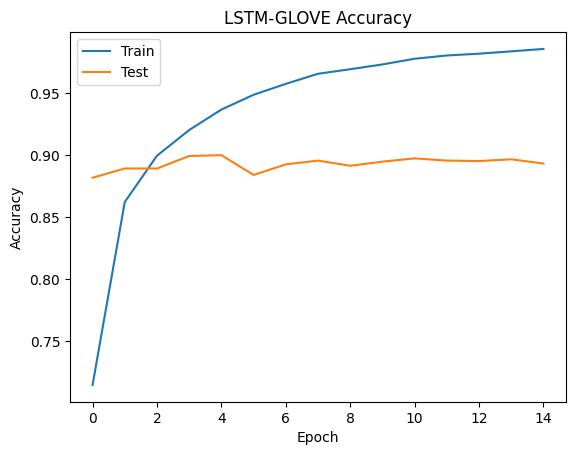

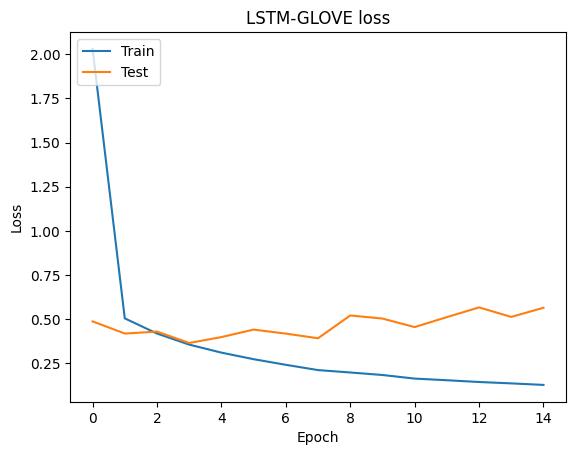

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM-GLOVE Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM-GLOVE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
